<a href="https://colab.research.google.com/github/pete602d/Pythonslange/blob/main/udrykning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Udringskøretejer og reaktionstider
Her simuleres trafiksituationer med bilister og udrykningskøretøjer. Formålet er at visualisere hvor langt tid biler har til at reagere på udrykningskøretøjer. Her sammenlignes den nuværende situation, hvor bilister skal lytte efter sirener, med en ny metode hvor de bliver advaret om udrykningskøretøjet på forhånd.  


In [ ]:
import random
import pandas as pd
import folium
import json
import geopandas as gpd
import time
from IPython.display import clear_output, display

antal_biler = 20
andel_med_alarm = 0.4
med_alarm = int(antal_biler * andel_med_alarm)
uden_alarm = antal_biler - med_alarm

uden_alarm_reaktionstid = [random.randint(5, 22) for _ in range(uden_alarm)]
med_alarm_reaktionstid = [random.randint(15, 45) for _ in range(med_alarm)]

samlet_forsinkelse = 0

#chance for forsinkelse
def forsinkelse_chance(reaktionstid, bilnummer, alarm_type):
  global samlet_forsinkelse
  if reaktionstid > 20:
    chance = 0
  elif reaktionstid < 10:
    chance = 100
  else:
    chance = int((20 - reaktionstid) / 10 * 100)
    return 0

#Simuleriung af forsinkelse
  if random.random() < chance / 100:
     # print(f"Bil {bilnummer} ({alarm_type}) har {reaktionstid} sekunder til at reagere og forsinker køretøjet")
      forsinkelse = random.randint(5, 10)
      samlet_forsinkelse += forsinkelse
      return forsinkelse
  else:
     # print(f"Bil {bilnummer} ({alarm_type}) har {reaktionstid} sekunder til at reagere og ikke forsinker køretøjet")
      return 0



forsinkelser_uden_alarm = []
for i, tid in enumerate(uden_alarm_reaktionstid):
    forsinkelser_uden_alarm.append(forsinkelse_chance(tid, i + 1, "uden alarm"))

forsinkelser_med_alarm = []
for i, tid in enumerate(med_alarm_reaktionstid):
    forsinkelser_med_alarm.append(forsinkelse_chance(tid, i + antal_biler // 2 + 1, "med alarm"))

#print(f"Den samlede forsinkelse af udrykningskøretøjet er {samlet_forsinkelse} sekunder")

#andel af fosinkelser for hver liste
andel_fors_uden_alarm = sum(1 for chance in forsinkelser_uden_alarm if chance > 0) / len(forsinkelser_uden_alarm) * 100
andel_fors_med_alarm = sum(1 for chance in forsinkelser_med_alarm if chance > 0) / len(forsinkelser_med_alarm) * 100

#print("Andel af biler uden alarm der forsinker: {:.2f}%".format(andel_uden_alarm))

#print("Andel af biler med alarm der forsinker: {:.2f}%".format(andel_med_alarm))

data = {
    "Bilnummer": list(range(1, antal_biler + 1)),
    "Advaret": ["Nej"] * uden_alarm + ["Ja"] * med_alarm,
    "Reaktionstid": uden_alarm_reaktionstid + med_alarm_reaktionstid,
    "Forsinkelse": forsinkelser_uden_alarm + forsinkelser_med_alarm
}

df = pd.DataFrame(data)

#display(df)


forsinkelse_data = {
    "Advarede biler (%)": (andel_med_alarm) *100 ,
    "Andel af ikke advarede biler der forsinker (%)": andel_fors_uden_alarm,
    "Andel af advarede biler der forsinker (%)": andel_fors_med_alarm,
    "Sekunder udrykningskøretøjets bliver forsinket": samlet_forsinkelse
}

forsinkelse_df = pd.DataFrame([forsinkelse_data])
#display(forsinkelse_df)




In [ ]:
#Kort
center_lat = 55.645234
center_lon = 12.124282

m = folium.Map(location=[center_lat, center_lon], zoom_start=13.2)

#Rute
geojson_route = "map (4).geojson"
with open(geojson_route, "r") as file:
    route_data = json.load(file)

folium.GeoJson(geojson_route, name="Rute", style_function=lambda x: {"color": "blue", "weight": 5}).add_to(m)

route_coords = route_data["features"][0]["geometry"]["coordinates"]
route_coords = [[lat, lon] for lon, lat in route_coords]  # Convert to [lat, lon] format




In [ ]:
#Biler på vejen
alle_biler = []
for i in range(antal_biler):
    bil_data = {
        "id": i + 1,
        "alarm": "Ja" if i >= uden_alarm else "Nej",
        "reaktionstid": med_alarm_reaktionstid[i - uden_alarm] if i >= uden_alarm else uden_alarm_reaktionstid[i],
        "forsinkelse": forsinkelser_med_alarm[i - uden_alarm] if i >= uden_alarm else forsinkelser_uden_alarm[i],
        "position": route_coords[int((i / antal_biler) * len(route_coords))]  # Spread evenly on route
    }
    alle_biler.append(bil_data)

for bil in alle_biler:
    color = "green" if bil["alarm"] == "Ja" else "blue"
    marker = folium.CircleMarker(
        location=bil["position"],
        radius=8,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=f"Bil {bil['id']} - Reaktionstid: {bil['reaktionstid']} sek"
    )
    marker.add_to(m)

    if bil["forsinkelse"] > 0:
        folium.CircleMarker(
            location=bil["position"],
            radius=4,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.9
        ).add_to(m)


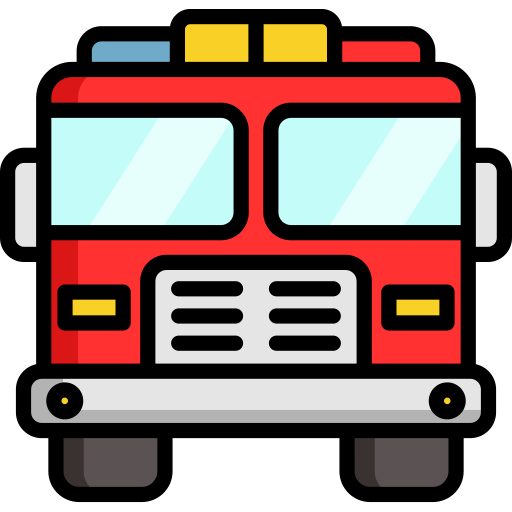

KeyboardInterrupt: 

In [ ]:
#Brandbil
brandbil_ikon = "fire-truck.png"
brandbil = folium.Marker(
    location=route_coords[0],
    icon=folium.CustomIcon(brandbil_ikon, icon_size=(30, 30)),
    popup="brandbil"
)
brandbil.add_to(m)

display(m)

#Simulering af bevægelse
antal_trin = 40
for step in range(antal_trin):
    #index for positioner
    position_index = int((step / antal_trin) * len(route_coords))
    #Brandbil bevægelse
    brandbil.location = route_coords[position_index]
    #forsinkelse
    time.sleep(0.5)

    clear_output(wait=True)
    display(m)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
